In [ ]:
# Test 3-4 Dataset C
# This test uses a simple CNN to classify between having an Square or a Circle

In [1]:
import numpy as np
import optuna as opt
from optuna.visualization import plot_optimization_history
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
tf.config.list_physical_devices('GPU')

2024-04-01 20:10:47.269290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 20:10:47.269320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 20:10:47.270646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 20:10:47.279560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 20:10:48.617597: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_dir = '../../Generator/Datasets/Dataset_C2/train'
test_dir = '../../Generator/Datasets/Dataset_C2/test'

In [3]:
IMG_SIZE = 250
BATCH_SIZE = 32

In [4]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    )

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    )

Found 2000 files belonging to 2 classes.


2024-04-01 20:10:54.271872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 20:10:54.273265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 20:10:54.276506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 1000 files belonging to 2 classes.


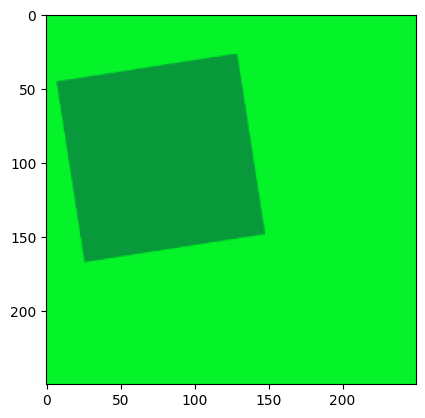

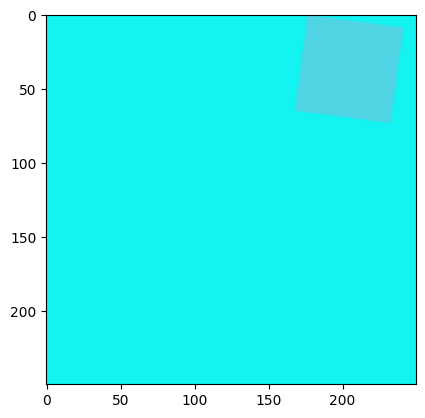

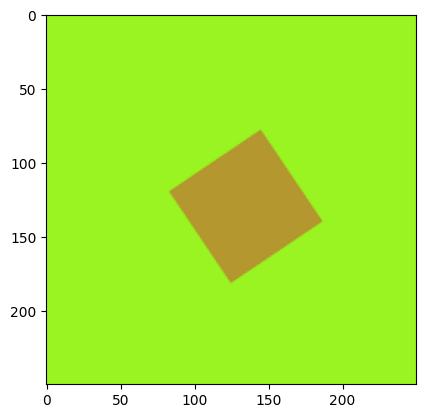

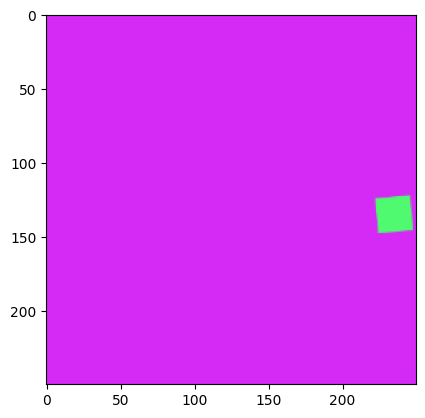

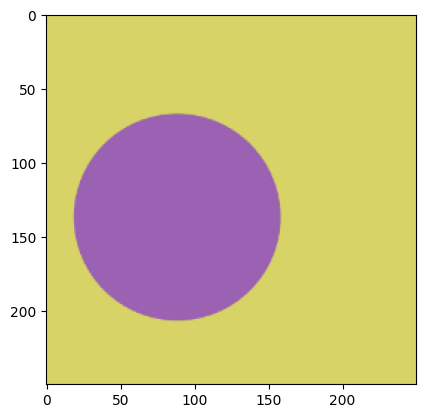

In [5]:
for data_batch, _ in train_dataset.take(1):
    for i in range(5):
        plt.imshow(data_batch[i].numpy().astype("uint8"))
        plt.show()

In [ ]:
checkpoint_filepath = 'models/3-4/ch-{epoch:03d}.ckpt'
callbacks = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)

In [ ]:
def objective(trial):
    opt_num_hidden_dense_units = trial.suggest_int("opt_num_hidden_dense_units", 10, 512)
    opt_lr = trial.suggest_float("opt_lr", 1e-6, 1e-2, log=True)
    opt_bs = trial.suggest_int("opt_bs", 16, 128)
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=4, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=8, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(opt_num_hidden_dense_units, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=opt_lr), metrics=['acc'])
    history = model.fit(train_dataset, epochs=10, batch_size=opt_bs, validation_data=test_dataset, callbacks=[callbacks])
    min_val_loss = np.amin(history.history["val_loss"])
    return min_val_loss

In [ ]:
study = opt.create_study()
study.optimize(objective, n_trials=15)

In [ ]:
plot_optimization_history(study)

In [ ]:
from optuna.visualization import plot_contour
plot_contour(study, params=["opt_lr", "opt_bs"])

In [ ]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [ ]:
best_params = study.best_params
found_opt_num_hidden_dense_units = best_params["opt_num_hidden_dense_units"]
found_opt_lr = best_params["opt_lr"]
found_opt_bs = best_params["opt_bs"]
print("Found num hidden dense units: {}".format(found_opt_num_hidden_dense_units))
print("Found learning rate: {}".format(found_opt_lr))
print("Found batch size: {}".format(found_opt_bs))

In [ ]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=4, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=8, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(found_opt_num_hidden_dense_units, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=found_opt_lr), 
    metrics=['acc'])

In [ ]:
#Best Epoch = ?

history = model.fit(train_dataset, epochs=20, batch_size=found_opt_bs, validation_data=test_dataset)

In [ ]:
history_2 = model.fit(train_dataset, epochs=10, batch_size=found_opt_bs, validation_data=test_dataset)

In [ ]:
history_3 = model.fit(train_dataset, epochs=20, batch_size=found_opt_bs, validation_data=test_dataset)

In [ ]:
history_4 = model.fit(train_dataset, epochs=30, batch_size=found_opt_bs, validation_data=test_dataset)

In [6]:
model = keras.models.load_model('models/3-4_old/3-4-C.keras')

In [ ]:
model.

In [7]:
val_loss, val_acc = model.evaluate(test_dataset, batch_size=64)
print(val_loss, val_acc)

2024-04-01 20:11:44.368236: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-01 20:11:44.527148: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


32/32 [==============================] - 3s 42ms/step - loss: 0.8406 - acc: 0.9130
0.8405951857566833 0.9129999876022339


In [ ]:
combined_history = {}
for fit_history in [history, history_2, history_3, history_4]: 
    epochs = range(1, len(fit_history.history['acc']) + 1) 

    for metric in ['acc', 'val_acc', 'loss', 'val_loss']:
        if metric not in combined_history:
            combined_history[metric] = []
        combined_history[metric].extend(fit_history.history[metric])

In [ ]:
acc = combined_history['acc']
val_acc = combined_history['val_acc']
loss = combined_history['loss']
val_loss = combined_history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("graphs/3-1/train_test_loss",dpi=100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("graphs/3-4/train_test_acc",dpi=100)
plt.show()


In [ ]:
model.save('models/3-4/3-4-C.keras')

In [9]:
import csv
with open('results/3-4/results.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Index', 'Label', 'Prediction'])
    for i, (data_batch, labels_batch) in enumerate(test_dataset):
        predictions = model.predict(data_batch)
        for j in range(len(predictions)):
            writer.writerow([i * BATCH_SIZE + j, labels_batch[j].numpy(), int(predictions[j][0].round())])

1/1 [==============================] - 0s 91ms/step


In [12]:
img = tf.keras.preprocessing.image.load_img('../../Generator/Datasets/Dataset_C/test/square/square_302.png', target_size=(IMG_SIZE, IMG_SIZE))

In [13]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)
result = model.predict(img_array)
print("Result: ", result.round())

(1, 250, 250, 3)
1/1 [==============================] - 0s 25ms/step
Result:  [[1.]]
